<a href="https://colab.research.google.com/github/RegmiYogesh/NASA_Glacial_vanguard/blob/main/NASA_spaceapp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image
import random
%matplotlib inline
import glob
from osgeo import gdal
from tensorflow import keras
from osgeo import osr
import pandas as pd

In [5]:
from PIL import Image
from tensorflow.python.keras import Model
from tensorflow.python.keras.layers import Conv2D, Input, MaxPooling2D, Conv2DTranspose, Concatenate, Dropout

In [4]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.metrics import Recall, Precision

In [ ]:
train_image_dir = sorted(glob.glob("/content/drive/MyDrive/DATA/Image/*.tif"))
train_mask_dir = sorted(glob.glob("/content/drive/MyDrive/DATA/Label/*.tif"))
test_image_dir = sorted(glob.glob("/content/drive/MyDrive/DATA/Image/*.tif"))
test_mask_dir = sorted(glob.glob("/content/drive/MyDrive/DATA/Label/*.tif"))
# pred_image_dir = sorted(glob.glob("B:/datasets/predict_crosswalk/images/*.tif"))
# print(len(train_image_dir),len(test_image_dir),len(pred_image_dir))

In [ ]:
len(train_image_dir)

33

**Converting the training files into numpy array**

In [ ]:
#converting the training images in numpy array
train_xx = np.zeros((33,512,512,3))
train_yy = np.zeros((33,512,512))

for i, (img, mask) in enumerate(zip(train_image_dir,train_mask_dir)):
    img = gdal.Open(img).ReadAsArray().transpose()
    np_img=cv2.resize(img,(512,512))
    train_xx[i] = np_img

    mask = gdal.Open(mask).ReadAsArray().transpose()
    np_mask=cv2.resize(mask,(512,512))
    train_yy[i] = np_mask

**Converting the test files into numpy array**

In [ ]:
#converting the test images in numpy array
test_xx = np.zeros((33,512,512,3))
test_yy = np.zeros((33,512,512))

for i, (img, mask) in enumerate(zip(test_image_dir,test_mask_dir)):
    img = gdal.Open(img).ReadAsArray().transpose()
    np_img=cv2.resize(img,(512,512))
    test_xx[i] = np_img

    mask = gdal.Open(mask).ReadAsArray().transpose()
    np_mask=cv2.resize(mask,(512,512))
    test_yy[i] = np_mask

In [ ]:
num_train = len(train_xx)
print (num_train)

33


In [ ]:
#random image number
img_num = random.randint(0, num_train-1)
img_num

24

**Plotting the image and mask**

In [ ]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(train_xx[img_num,:,:,:].astype('uint8'))
plt.title("Image")
plt.subplot(1,2,2)
plt.imshow(train_yy[img_num,:,:].astype('uint8'))
plt.title("Mask")
#plt.show()

**Model Preparation**

In [ ]:
img_size = 512

# training attributes
batch_size = 64
epochs = 100


In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size), kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

In [ ]:


def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)

    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
input_img = Input((512, 512, 3), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy", Recall(), Precision()])

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ img (InputLayer)          │ (None, 512, 512, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 512, 512, 16)   │            448 │ img[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 512, 512, 16)   │             64 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 512, 512, 16)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 512, 512, 16)   │          2,320 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 512, 512, 16)   │             64 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 512, 512, 16)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 256, 256, 16)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 256, 256, 16)   │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 256, 256, 32)   │          4,640 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 256, 256, 32)   │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 256, 256, 32)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 256, 256, 32)   │          9,248 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 256, 256, 32)   │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 256, 256, 32)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 128, 128, 32)   │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)  

 Total params: 2,164,593 (8.26 MB)

 Trainable params: 2,161,649 (8.25 MB)

 Non-trainable params: 2,944 (11.50 KB)

**Training the model**

In [ ]:
History = model.fit(train_xx, train_yy, validation_data=(test_xx, test_yy), epochs=20, batch_size=5, verbose=1)
model.save('model_100_epochs.h5')

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 91s 7s/step - accuracy: 0.9917 - loss: nan - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9908 - val_loss: nan - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 273ms/step - accuracy: 0.9905 - loss: nan - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9908 - val_loss: nan - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - accuracy: 0.9906 - loss: nan - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9908 - val_loss: nan - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.9921 - loss: nan - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9908 - val_loss: nan - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 267ms/step - accuracy: 0.9909 - loss: nan - precision: 0.0000e+00 - recall: 0.0000e+00 - va

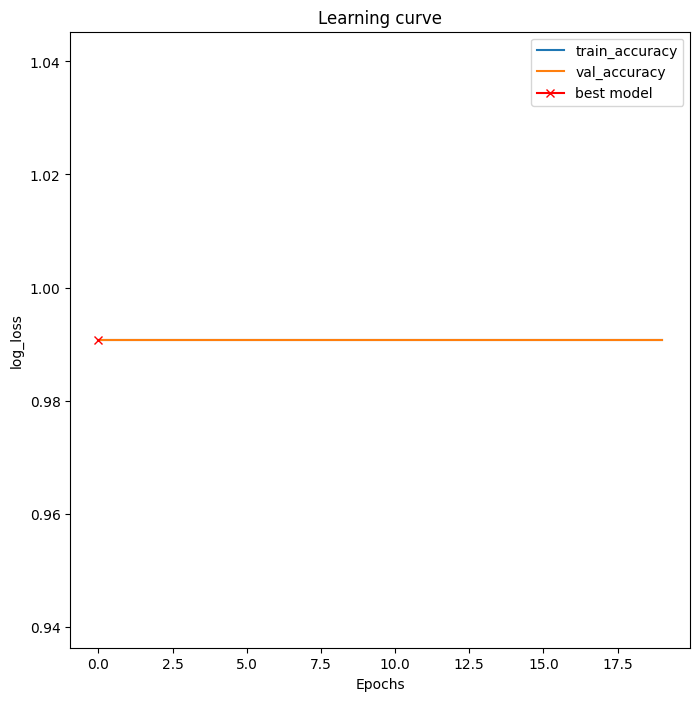

In [ ]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(History.history["accuracy"], label="train_accuracy")
plt.plot(History.history["val_accuracy"], label="val_accuracy")
plt.plot( np.argmin(History.history["val_accuracy"]), np.min(History.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();
plt.show()

In [6]:
import ee
import geopandas as gpd
import requests
import os

In [7]:
ee.Authenticate()

In [8]:
ee.Initialize(project='yogesh-376506')

In [9]:
aoi_path =r'/content/drive/MyDrive/Nepal_data.shp/solukhumbu.shp'

In [10]:
 gdf = gpd.read_file(aoi_path)
aoi_geometry = gdf.geometry[0]

In [11]:
geojson_geometry = aoi_geometry.__geo_interface__
ee_geometry = ee.Geometry(geojson_geometry)

In [16]:
img_collection = ee.ImageCollection("COPERNICUS/S2_HARMONIZED").filterBounds(ee_geometry).filterDate('2023-01-01','2023-12-31').filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 5)).sort('CLOUDY_PIXEL_PERCENTAGE').first().clip(ee_geometry)

In [15]:
# prompt: i want to visualize above image collection using geemap

import geemap

# Create a map centered on the area of interest
Map = geemap.Map()
Map.centerObject(ee_geometry, 10)

# Add the image collection to the map
Map.addLayer(img_collection, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, 'Sentinel-2 Image')

# Display the map
Map


Map(center=[27.709968581256234, 86.72287284144191], controls=(WidgetControl(options=['position', 'transparent_…

In [ ]:
# Step 3: Read AOI Shapefile
def read_shapefile(aoi_shp_path):
    """Reads the AOI shapefile and returns the GeoDataFrame and the geometry."""
    gdf = gpd.read_file(aoi_shp_path)

    # Check if shapefile has been correctly loaded
    if gdf.empty:
        raise ValueError("Error: AOI shapefile is empty or invalid.")

    # Get the first geometry of the shapefile (assuming a single AOI)
    aoi_geometry = gdf.geometry[0]

    return gdf, aoi_geometry

# Step 4: Convert Shapefile Geometry to GeoJSON for GEE
def convert_geometry_to_gee(aoi_geometry):
    """Convert shapefile geometry into GEE-compatible JSON geometry."""
    geojson_geometry = aoi_geometry.__geo_interface__
    ee_geometry = ee.Geometry(geojson_geometry)
    return ee_geometry

# Step 5: Download Sentinel-2 Imagery Using the AOI Geometry
def download_sentinel_image(ee_geometry, download_dir='downloads', start_date='2023-01-01', end_date='2023-12-31', cloud_percentage=10):
    """Downloads Sentinel-2 imagery based on the AOI and saves it locally as TIFF."""

    # Create download directory if it doesn't exist
    if not os.path.exists(download_dir):
        os.makedirs(download_dir)

    # Load Sentinel-2 image collection
    sentinel2_collection = ee.ImageCollection("COPERNICUS/S2") \
        .filterBounds(ee_geometry) \
        .filterDate(start_date, end_date) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', cloud_percentage)) \
        .sort('CLOUDY_PIXEL_PERCENTAGE') \
        .first()

    # Get download URL for Sentinel-2 image in TIFF format
    image_url = sentinel2_collection.getDownloadURL({
        'scale': 10,  # Sentinel-2 has a 10m resolution for most bands
        'region': ee_geometry
    })

    # Download the image and save it as a TIFF
    response = requests.get(image_url)
    tiff_image_path = os.path.join(download_dir, 'sentinel2_image.tiff')
    with open(tiff_image_path, 'wb') as file:
        file.write(response.content)

    print(f"Sentinel-2 image downloaded and saved at: {tiff_image_path}")
    return tiff_image_path

# Example Usage

# Path to your AOI shapefile (replace with the correct path)
aoi_shp_path = '/content/drive/MyDrive/Nepal_data.shp/Country_boundary.shp'

# Read the shapefile and extract the geometry
gdf, aoi_geometry = read_shapefile(aoi_shp_path)

# Convert geometry to GEE-compatible format
ee_geometry = convert_geometry_to_gee(aoi_geometry)

# Download Sentinel-2 image based on AOI
downloaded_image_path = download_sentinel_image(ee_geometry)

/usr/local/lib/python3.10/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for COPERNICUS/S2! You are using a deprecated asset.
To ensure continued functionality, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2

  warnings.warn(warning, category=DeprecationWarning)


EEException: Pixel grid dimensions (80765x44089) must be less than or equal to 32768.